# Poker AI Setup

## Imports

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pokerenv.obs_indices as indices
from pokerenv.table import Table
from treys import Deck, Evaluator, Card
from pokerenv.common import GameState, PlayerState, PlayerAction, TablePosition, Action, action_list
from pokerenv.player import Player
from pokerenv.utils import pretty_print_hand, approx_gt, approx_lte
import types
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import gym
import math
import time
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn.functional import huber_loss, cross_entropy
from collections import deque


## Create enviorment

In [97]:
class ModifiedTable(Table):
    def __init__(self, n_players, player_names=None, track_single_player=False, stack_low=50, stack_high=200, hand_history_location='hands/', invalid_action_penalty=0):
        super().__init__(n_players, player_names, track_single_player, stack_low, stack_high, hand_history_location, invalid_action_penalty)
        
    def _int_to_str(card_int: int) -> str:
        rank_int = Card.get_rank_int(card_int)
        suit_int = Card.get_suit_int(card_int)
        return Card.STR_RANKS[rank_int] + Card.INT_SUIT_TO_CHAR_SUIT[suit_int]
    
    def _get_rank_int(card_int: int) -> int:
        if card_int is int:
            return (card_int >> 8) & 0xF
        else:
            return (card_int[0] >> 8) & 0xF
        
    def _get_suit_int(card_int: int) -> int:
        if card_int is int:
            return (card_int >> 12) & 0xF
        else:
            return (card_int[0] >> 12) & 0xF
        
    def _get_bitrank_int(card_int: int) -> int:
        if card_int is int:
            return (card_int >> 16) & 0x1FFF
        else:
            return (card_int[0] >> 16) & 0x1FFF

    def _get_prime(card_int: int) -> int:
        if card_int is int:
            return card_int & 0x3F
        else:
            return card_int[0] & 0x3F

    def _street_transition(self, transition_to_end=False):
            transitioned = False
            if self.street == GameState.PREFLOP:
                self.cards = self.deck.draw(3)
                self._write_event("*** FLOP *** [%s %s %s]" %
                                (Card.int_to_str(self.cards[0]), Card.int_to_str(self.cards[1]),
                                Card.int_to_str(self.cards[2])))
                self.street = GameState.FLOP
                transitioned = True
            if self.street == GameState.FLOP and (not transitioned or transition_to_end):
                new = self.deck.draw(1)[0]
                self.cards.append(new)
                self._write_event("*** TURN *** [%s %s %s] [%s]" %
                                (Card.int_to_str(self.cards[0]), Card.int_to_str(self.cards[1]),
                                Card.int_to_str(self.cards[2]), Card.int_to_str(self.cards[3])))
                self.street = GameState.TURN
                transitioned = True
            if self.street == GameState.TURN and (not transitioned or transition_to_end):
                new = self.deck.draw(1)[0]
                self.cards.append(new)
                self._write_event("*** RIVER *** [%s %s %s %s] [%s]" %
                                (Card.int_to_str(self.cards[0]), Card.int_to_str(self.cards[1]),
                                Card.int_to_str(self.cards[2]), Card.int_to_str(self.cards[3]),
                                Card.int_to_str(self.cards[4])))
                self.street = GameState.RIVER
                transitioned = True
            if self.street == GameState.RIVER and (not transitioned or transition_to_end):
                if not self.hand_is_over:
                    if self.hand_history_enabled:
                        self._write_show_down()
                self.hand_is_over = True
            self.street_finished = False
            self.last_bet_placed_by = None
            self.first_to_act = None
            self.bet_to_match = 0
            self.minimum_raise = 0
            for player in self.players:
                player.finish_street()

    def step(self, action: Action):
        BB = 5
        self.current_player_i = self.next_player_i
        player = self.players[self.current_player_i]
        self.current_turn += 1

        if (player.all_in or player.state is not PlayerState.ACTIVE) and not self.hand_is_over:
            raise Exception("A player who is inactive or all-in was allowed to act")
        if self.first_to_act is None:
            self.first_to_act = player

        # Apply the player action
        if not (self.hand_is_over or self.street_finished):
            valid_actions = self._get_valid_actions(player)
            if not self._is_action_valid(player, action, valid_actions):
                player.punish_invalid_action()
            elif action.action_type is PlayerAction.FOLD:
                player.fold()
                self.active_players -= 1
                self._write_event("%s: folds" % player.name)
            elif action.action_type is PlayerAction.CHECK:
                player.check()
                self._write_event("%s: checks" % player.name)
            elif action.action_type is PlayerAction.CALL:
                call_size = player.call(self.bet_to_match)
                self.pot += call_size
                if player.all_in:
                    self._write_event("%s: calls $%.2f and is all-in" % (player.name, call_size * BB))
                else:
                    self._write_event("%s: calls $%.2f" % (player.name, call_size * BB))
            elif action.action_type is PlayerAction.BET:
                previous_bet_this_street = player.bet_this_street
                actual_bet_size = player.bet(np.round(action.bet_amount, 2))
                self.pot += actual_bet_size
                if self.bet_to_match == 0:
                    if player.all_in:
                        self._write_event("%s: bets $%.2f and is all-in" % (player.name, actual_bet_size * BB))
                    else:
                        self._write_event("%s: bets $%.2f" % (player.name, actual_bet_size * BB))
                else:
                    if player.all_in:
                        self._write_event("%s: raises $%.2f to $%.2f and is all-in" %
                                            (player.name,
                                            ((actual_bet_size + previous_bet_this_street) - self.bet_to_match) * BB,
                                            (actual_bet_size + previous_bet_this_street) * BB)
                                            )
                    else:
                        self._write_event("%s: raises $%.2f to $%.2f" %
                                            (player.name,
                                            ((actual_bet_size + previous_bet_this_street) - self.bet_to_match) * BB,
                                            (actual_bet_size + previous_bet_this_street) * BB)
                                            )
                self._change_bet_to_match(actual_bet_size + previous_bet_this_street)
                self.last_bet_placed_by = player
            else:
                raise Exception("Error when parsing action, make sure player action_type is PlayerAction and not int")

            should_transition_to_end = False
            players_with_actions = [p for p in self.players if p.state is PlayerState.ACTIVE if not p.all_in]
            players_who_should_act = [p for p in players_with_actions if (not p.acted_this_street or p.bet_this_street != self.bet_to_match)]

            # If the game is over, or the betting street is finished, progress the game state
            if len(players_with_actions) < 2 and len(players_who_should_act) == 0:
                amount = 0
                # If all active players are all-in, transition to the end, allowing no actions in the remaining streets
                if self.active_players > 1:
                    biggest_bet_call = max(
                        [p.bet_this_street for p in self.players
                            if p.state is PlayerState.ACTIVE if p is not self.last_bet_placed_by]
                    )
                    last_bet_this_street = 0
                    if self.last_bet_placed_by is not None:
                        last_bet_this_street = self.last_bet_placed_by.bet_this_street
                    if biggest_bet_call < last_bet_this_street:
                        amount = last_bet_this_street - biggest_bet_call
                    should_transition_to_end = True
                # If everyone else has folded, end the hand
                else:
                    self.hand_is_over = True
                    amount = self.minimum_raise
                # If there are uncalled bets, return them to the player who placed them
                if amount > 0:
                    self.pot -= amount
                    self.last_bet_placed_by.stack += amount
                    self.last_bet_placed_by.money_in_pot -= amount
                    self.last_bet_placed_by.bet_this_street -= amount
                    self._write_event(
                        "Uncalled bet ($%.2f) returned to %s" % (amount * BB, self.last_bet_placed_by.name)
                    )
                if should_transition_to_end:
                    self._street_transition(transition_to_end=True)
            # If the betting street is still active, choose next player to act
            else:
                active_players_after = [i for i in range(self.n_players) if i > self.current_player_i if
                                        self.players[i].state is PlayerState.ACTIVE if not self.players[i].all_in]
                active_players_before = [i for i in range(self.n_players) if i <= self.current_player_i if
                                            self.players[i].state is PlayerState.ACTIVE if not self.players[i].all_in]
                if len(active_players_after) > 0:
                    self.next_player_i = min(active_players_after)
                else:
                    self.next_player_i = min(active_players_before)
                next_player = self.players[self.next_player_i]
                if self.last_bet_placed_by is next_player or (self.first_to_act is next_player and self.last_bet_placed_by is None):
                    self.street_finished = True
                    if len(active_players_before) > 0:
                        self.next_player_i = min(active_players_before)

        if self.street_finished and not self.hand_is_over:
            self._street_transition()

        obs = np.zeros(self.observation_space.shape[0]) if self.hand_is_over else self._get_observation(self.players[self.next_player_i])
        rewards = np.asarray([player.get_reward() for player in sorted(self.players)])
        if self.hand_is_over:
            self._distribute_pot()
            self._finish_hand()
            
        return obs, rewards, self.hand_is_over, {}

In [98]:
# Create the enviorment:
def createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player=False):
    table = ModifiedTable(active_players, 
                player_names=player_names,
                track_single_player=track_single_player,
                stack_low=low_stack_bbs,
                stack_high=high_stack_bbs,
                hand_history_location=hand_history_location,
                invalid_action_penalty=invalid_action_penalty
    )
    table.seed(1)
    return table
            

## Env Modifications

## Learning Loop

In [99]:
def learningLoop(table, agents, active_players, n_iterations):
    iteration = 1
    playerWinnings = [[0 for player in table.players]]
    winners = []
    while True:
        if iteration % 50 == 0:
            table.hand_history_enabled = True
        table.n_players = active_players
        for agent in agents:
            if hasattr(agent, "update_policy"):
                agent.update_policy(winners)
                
            
            agent.reset()
        obs = table.reset()
        winners = []
        acting_player = int(obs[indices.ACTING_PLAYER])
        while True:
            action = agents[acting_player].get_action(obs)
            obs, reward, done, _ = table.step(action)
            if  done:
                # Distribute final rewards
                for i in range(active_players):
                    agents[i].rewards.append(reward[i])
                break
            else:
                # This step can be skipped unless invalid action penalty is enabled, 
                # since we only get a reward when the pot is distributed, and the done flag is set
                agents[acting_player].rewards.append(reward[acting_player])
                acting_player = int(obs[indices.ACTING_PLAYER])
        iteration += 1
        playerWinnings.append([player.winnings for player in table.players])
        
        for agent, player in zip(agents, table.players):
            if player.winnings > 0:
                winners.append((agent, player))
                
        table.hand_history_enabled = False
        if iteration % 250 == 0:
            print("Iteration: ", iteration)
        
        if iteration >= n_iterations:
            break
    
    return playerWinnings

# Agents

## Random Agent

In [100]:
# Agent that makes random actions
class RandomAgent:
    def __init__(self):
        self.actions = []
        self.observations = []
        self.rewards = []

    def get_action(self, observation):
        self.observations.append(observation)
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        valid_bet_low = observation[indices.VALID_BET_LOW]
        valid_bet_high = observation[indices.VALID_BET_HIGH]
        chosen_action = PlayerAction(np.random.choice(valid_actions))
        bet_size = 0
        if chosen_action is PlayerAction.BET:
            bet_size = np.random.uniform(valid_bet_low, valid_bet_high)
        table_action = Action(chosen_action, bet_size)
        self.actions.append(table_action)
        return table_action

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []

## Fold Agent

In [101]:
# Agent that always folds
class FoldAgent:
    def __init__(self):
        self.actions = []
        self.observations = []
        self.rewards = []

    def get_action(self, observation):
        self.observations.append(observation)
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        chosen_action = PlayerAction.FOLD
        table_action = Action(chosen_action, 0)
        self.actions.append(table_action)
        return table_action

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []

## Determined Agent

In [102]:
# Agent that never folds
class DeterminedAgent:
    def __init__(self):
        self.actions = []
        self.observations = []
        self.rewards = []

    def get_action(self, observation):
        self.observations.append(observation)
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        chosen_action = PlayerAction.CALL
        valid_bet_low = observation[indices.VALID_BET_LOW]
        valid_bet_high = observation[indices.VALID_BET_HIGH]
        table_action = Action(chosen_action, 0)
        self.actions.append(table_action)
        return table_action

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []

## Aggressive agent

In [103]:
# Agent that always raises
class AggressiveAgent:
    def __init__(self):
        self.actions = []
        self.observations = []
        self.rewards = []

    def get_action(self, observation):
        self.observations.append(observation)
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        chosen_action = PlayerAction.BET
        valid_bet_low = observation[indices.VALID_BET_LOW]
        valid_bet_high = observation[indices.VALID_BET_HIGH]
        table_action = Action(chosen_action, valid_bet_high)
        self.actions.append(table_action)
        return table_action

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []
        
    

## Chance agent

In [104]:
# Agent that uses encoded hand values to make decisions
class ValueAgent:
    def __init__(self, value_model):
        self.actions = []
        self.observations = []
        self.rewards = []
        self.value_model = value_model

    def get_action(self, observation):
        self.observations.append(observation)
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        valid_bet_low = observation[indices.VALID_BET_LOW]
        valid_bet_high = observation[indices.VALID_BET_HIGH]
        hand_value = observation[indices.ACTING_PLAYER_STACK_SIZE]
        pot_size = observation[indices.POT_SIZE]
        bet_value = self.value_model.predict(np.array([[hand_value, pot_size]]))[0][0]
        
        if bet_value > 0.5:
            chosen_action = PlayerAction.BET
            bet_size = np.random.uniform(valid_bet_low, valid_bet_high)
        elif valid_bet_high == 0.0:
            chosen_action = PlayerAction.CALL
        else:
            chosen_action = PlayerAction.FOLD
        table_action = Action(chosen_action, bet_size)
        self.actions.append(table_action)
        return table_action

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []

## Q-Learning Agent

In [105]:
class QLearningAgent:
    def __init__(self, eta=0.1, gamma=0.95, epsilon=0.1):
        self.q_table = {}  # Q-table to store state-action values
        self.eta = eta      # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate

        self.actions = []
        self.observations = []
        self.rewards = []

    def get_action(self, observation):
        # Convert observation into a hashable state
        state = tuple(observation)

        # Get valid actions dynamically
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()

        # Initialize Q-values for new states
        if state not in self.q_table:
            self.q_table[state] = {action: 0.0 for action in valid_actions}

        # Epsilon-greedy action selection
        if np.random.rand() < self.epsilon:
            chosen_action = np.random.choice(valid_actions)
        else:
            # Choose action with the highest Q-value
            chosen_action = max(self.q_table[state], key=self.q_table[state].get)

        # Convert chosen action to PlayerAction enum
        chosen_action = PlayerAction(chosen_action)

        # Determine bet size if the action is BET
        bet_size = 0
        if chosen_action == PlayerAction.BET:
            valid_bet_low = observation[indices.VALID_BET_LOW]
            valid_bet_high = observation[indices.VALID_BET_HIGH]
            bet_size = np.random.uniform(valid_bet_low, valid_bet_high)

        # Create the action object
        table_action = Action(chosen_action, bet_size)
        self.actions.append(table_action)
        self.observations.append(observation)
        return table_action

    def _get_reward(self, observation, winners):
        winning_agents = [agent for agent, player in winners]
        winning_players = [player for agent, player in winners]
        pot = observation[indices.POT_SIZE]
        
        if self in winning_agents:
            winning_idx = winning_agents.index(self)
            player = winning_players[winning_idx]
            stack = player.stack
            return 
        else:
            return 0
    
    def update_policy(self, winners):
        # Update Q-values using the Q-learning update rule
        for i in range(len(self.observations)):
            state = tuple(self.observations[i])
            action = self.actions[i]
            reward = self._get_reward(self.observations[i], winners)
            next_state = tuple(self.observations[i + 1]) if i + 1 < len(self.observations) else None

            if next_state is not None:
                next_max = max(self.q_table[next_state].values())
            else:
                next_max = 0

            self.q_table[state][action.action_type.value] += self.eta * (
                reward + self.gamma * next_max - self.q_table[state][action.action_type.value]
            )

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []

## REgression to RElative REward Based RL Agent

In [106]:
class ReplayBuffer:
    def __init__(self, capacity):
        """
        Initialize the replay buffer.
        Args:
            capacity (int): Maximum number of transitions to store.
        """
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        """
        Add a transition to the replay buffer.
        Args:
            state (np.array): Current state.
            action (Action): Action taken (includes type and bet value).
            reward (float): Reward received.
            next_state (np.array): Next state after the action.
            done (bool): Whether the episode ended after this transition.
        """
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        """
        Sample a batch of transitions.
        Args:
            batch_size (int): Number of transitions to sample.
        Returns:
            tuple: Batches of states, actions, rewards, next_states, and dones.
        """
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        return (
            np.array(states),
            np.array([a.action_type.value for a in actions]),  # Discrete action type
            np.array([a.value for a in actions]),  # Bet value
            np.array(rewards),
            np.array(next_states),
            np.array(dones),
        )
    
    def __len__(self):
        """
        Return the current size of the buffer.
        """
        return len(self.buffer)


In [107]:
from treys import Evaluator, Card
from treys.lookup import LookupTable

evaluator = Evaluator()

def featurize_hand(player_hand, community_cards):
    """
    Extract hand strength metrics for a player.
    Args:
        player_hand (list): List of player's private cards (e.g., [Card.new('As'), Card.new('Kd')]).
        community_cards (list): List of community cards.
    Returns:
        list: Hand strength metrics.
    """
    hand_strengths = [0] * 9

    # Combine player hand and community cards
    full_hand = player_hand + community_cards

    # Handle fewer than five cards (pre-flop and incomplete stages)
    if len(full_hand) < 5:
        return hand_strengths  # Default metrics for incomplete hands

    # Evaluate hand and get its rank and classification
    score = evaluator.evaluate(player_hand, community_cards)
    classification = evaluator.get_rank_class(score)

    # Hand strength metrics
    hand_strengths[0] = 1 if classification == LookupTable.MAX_TO_RANK_CLASS[LookupTable.MAX_HIGH_CARD] else 0  # High Card
    hand_strengths[1] = 1 if classification == LookupTable.MAX_TO_RANK_CLASS[LookupTable.MAX_PAIR] else 0  # Pair
    hand_strengths[2] = 1 if classification == LookupTable.MAX_TO_RANK_CLASS[LookupTable.MAX_THREE_OF_A_KIND] else 0  # Three of a Kind
    hand_strengths[3] = 1 if classification == LookupTable.MAX_TO_RANK_CLASS[LookupTable.MAX_FOUR_OF_A_KIND] else 0  # Four of a Kind
    hand_strengths[4] = 1 if classification == LookupTable.MAX_TO_RANK_CLASS[LookupTable.MAX_STRAIGHT] else 0  # Straight
    hand_strengths[5] = 1 if classification == LookupTable.MAX_TO_RANK_CLASS[LookupTable.MAX_FLUSH] else 0  # Flush
    hand_strengths[6] = 1 if classification == LookupTable.MAX_TO_RANK_CLASS[LookupTable.MAX_ROYAL_FLUSH] else 0  # Royal Flush
    hand_strengths[7] = 1 if classification == LookupTable.MAX_TO_RANK_CLASS[LookupTable.MAX_FULL_HOUSE] else 0  # Full House
    hand_strengths[8] = 1 if classification == LookupTable.MAX_TO_RANK_CLASS[LookupTable.MAX_STRAIGHT_FLUSH] else 0  # Straight Flush

    return hand_strengths


In [108]:
import numpy as np

def featurize_opponents(opponent_bets):
    """
    Extract betting metrics for all opponents.
    Args:
        opponent_bets (list of lists): Each sublist contains bets made by an opponent.
    Returns:
        list: Aggregated betting metrics for all opponents.
    """
    features = []
    for bets in opponent_bets:
        if len(bets) > 3:
            features.append(np.min(bets))  # Low bet
            features.extend(np.percentile(bets, [25, 50, 75]))  # Q1, median, Q3
            features.append(np.mean(bets))  # Mean bet
            features.append(np.max(bets))  # Max bet
            features.append(np.std(bets))  # Std dev of bets
            features.append(bets[len(bets)-1])  # Latest bet
        else:
            features.extend([0] * 8)  # Default values for missing bets
    return features


In [109]:
def featurize_state(player_hand, community_cards, opponent_bets):
    """
    Combine hand and opponent metrics into a single state vector.
    Args:
        player_hand (list): Player's private cards.
        community_cards (list): Community cards.
        opponent_bets (list of lists): Each sublist contains bets made by an opponent.
    Returns:
        np.array: Full state vector.
    """
    hand_features = featurize_hand(player_hand, community_cards)
    opponent_features = featurize_opponents(opponent_bets)
    return np.array(hand_features + opponent_features)


In [110]:
class ValueNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ValueNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.model(x)

In [111]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_actions):
        super(PolicyNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, num_actions),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.model(x)

In [112]:
class BetValueNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BetValueNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, x):
        return self.model(x)

In [113]:
class REBELAgent:
    def __init__(self, num_players, hidden_size=64, lr=1e-3, gamma=0.99):
        state_dim = 9 + 8 * num_players  # Hand strength metrics + betting metrics for all opponents
        self.state_dim = state_dim  # Hand strength metrics + betting metrics for all opponents
        self.gamma = gamma

        # Networks
        self.value_network = ValueNetwork(state_dim, hidden_size, 1)
        self.policy_network = PolicyNetwork(state_dim, hidden_size, 4)  # 4 actions: CHECK, FOLD, BET, CALL
        self.bet_value_network = BetValueNetwork(state_dim, hidden_size)

        # Optimizers
        self.value_optimizer = Adam(self.value_network.parameters(), lr=lr)
        self.policy_optimizer = Adam(self.policy_network.parameters(), lr=lr)
        self.bet_value_optimizer = Adam(self.bet_value_network.parameters(), lr=lr)

        # Replay Buffer
        self.replay_buffer = deque(maxlen=10000)
        self.scaler = StandardScaler()

        # Dummy fit for the scaler to prevent NotFittedError
        dummy_data = np.zeros((1, state_dim))
        self.scaler.fit(dummy_data)

    def fit_scaler(self, states):
        """
        Fit the scaler with a batch of states.
        Args:
            states: A batch of state observations.
        """
        self.scaler.fit(states)

    def get_action(self, observation):
        """
        Decide the action based on the observation.
        Outputs both the action type and the bet value if applicable.
        """
        # Scale the observation
        observation = self.scaler.transform([observation])[0]
        state_tensor = torch.FloatTensor(observation).unsqueeze(0)

        # Policy network for discrete action
        action_probs = self.policy_network(state_tensor).detach().numpy().flatten()
        chosen_action = np.random.choice(4, p=action_probs)

        if chosen_action == 2:  # BET
            # Bet/raise requires a value
            bet_value = self.bet_value_network(state_tensor).detach().item()
            return Action(PlayerAction.BET, max(0, bet_value))  # Ensure bet is non-negative
        elif chosen_action == 3:  # CALL
            return Action(PlayerAction.CALL, 0)
        elif chosen_action == 0:  # CHECK
            return Action(PlayerAction.CHECK, 0)
        else:  # FOLD
            return Action(PlayerAction.FOLD, 0)

    def store_transition(self, state, action, reward, next_state):
        """
        Store state-action-reward-next_state transitions for training.
        """
        self.replay_buffer.append((state, action, reward, next_state))

    def train(self, batch_size=32):
        if len(self.replay_buffer) < batch_size:
            return

        batch = random.sample(self.replay_buffer, batch_size)
        states, actions, rewards, next_states = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor([a.action_type.value for a in actions])
        bet_values = torch.FloatTensor([a.value for a in actions])
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)

        # Update Value Network
        with torch.no_grad():
            next_values = self.value_network(next_states).squeeze()
            target_values = rewards + self.gamma * next_values
        current_values = self.value_network(states).squeeze()
        value_loss = nn.MSELoss()(current_values, target_values)
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()

        # Update Policy Network
        advantages = (target_values - current_values).detach()
        action_probs = self.policy_network(states)
        action_log_probs = torch.log(action_probs.gather(1, actions.unsqueeze(-1)).squeeze())
        policy_loss = -(advantages * action_log_probs).mean()
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        # Update Bet Value Network
        bet_value_loss = nn.MSELoss()(self.bet_value_network(states).squeeze(), bet_values)
        self.bet_value_optimizer.zero_grad()
        bet_value_loss.backward()
        self.bet_value_optimizer.step()
        
    def reset(self):
        self.replay_buffer = deque(maxlen=10000)
        self.scaler = StandardScaler()
        dummy_data = np.zeros((1, self.state_dim))
        self.scaler.fit(dummy_data)
        


# Run Throughs

In [114]:
def learningLoop(table, agents, active_players, n_iterations, batch_size=32, train_interval=1):
    """
    Main loop for training agents in the poker environment.
    
    Args:
        table: The poker environment/table.
        agents: List of agents, including REBELAgent.
        active_players: Number of active players at the table.
        n_iterations: Number of hands to play.
        batch_size: Batch size for training the agents.
        train_interval: Number of hands between training phases.

    Returns:
        playerWinnings: List of winnings for each player after each hand.
    """
    iteration = 1
    playerWinnings = [[0 for _ in table.players]]
    playerWins = [0 for _ in table.players]
    playerBets = [[] for _ in table.players]
    
    initial_states = []
    for _ in range(100):  # Collect 100 initial observations
        table.n_players = active_players
        obs = table.reset()
        acting_player = int(obs[indices.ACTING_PLAYER])
        for agent in agents:
            if isinstance(agent, REBELAgent):
                playerCards = table.players[acting_player].cards  # Replace with correct player handling
                communityCards = table.cards
                state = featurize_state(playerCards, communityCards, playerBets)
                initial_states.append(state)

    # Fit scalers for all agents
    for agent in agents:
        if isinstance(agent, REBELAgent):
            agent.fit_scaler(np.array(initial_states))

    while iteration <= n_iterations:
        # Enable hand history logging every 50 iterations
        if iteration % 50 == 0:
            table.hand_history_enabled = True

        # Reset table and agents
        table.n_players = active_players
        obs = table.reset()
        

        acting_player = int(obs[indices.ACTING_PLAYER])
        done = False
        
        for agent in agents:
            agent.reset()

        while not done:
            current_player = table.players[acting_player]
            agent = agents[acting_player]
            playerCards = current_player.cards
            communityCards = table.cards
            if isinstance(agent, REBELAgent):
                state = featurize_state(playerCards, communityCards, playerBets)

            # Fetch action from the agent
            if isinstance(agent, REBELAgent):
                action = agent.get_action(state)
            else:
                action = agent.get_action(obs)    
            
            # Step the environment
            next_obs, reward, done, _ = table.step(action)

            # Track betting data
            playerBet = current_player.bet_this_street
            playerBets[acting_player].append(playerBet)
            
            if done:
                break
            
            if isinstance(agent, REBELAgent):
                # Calculate the next state for the REBEL agent
                nextState = featurize_state(playerCards[0:2], playerCards[2:], playerBets)

                # Store transition in the agent's replay buffer
                agent.store_transition(state, action, 0, nextState)

            # Update observation and acting player
            obs = next_obs
            acting_player = int(obs[indices.ACTING_PLAYER])

        # Track winnings and winners
        playerWinnings.append([player.winnings for player in table.players])
        maxWinnings = max(playerWinnings[-1])
        for agent, player in zip(agents, table.players):
            if player.winnings == maxWinnings:
                playerWins[table.players.index(player)] += 1
            if isinstance(agent, REBELAgent):
                nextState = featurize_state(playerCards, communityCards, playerBets)
                if player.winnings == maxWinnings:
                    agent.store_transition(state, action, 1, nextState)
                else:
                    agent.store_transition(state, action, -1, nextState) 
                
                # Train agents
                if iteration % train_interval == 0:
                    for agent in agents:
                        if hasattr(agent, "train"):
                            agent.train(batch_size)

        # Disable hand history logging
        table.hand_history_enabled = False

        # Print progress every 250 iterations
        if iteration % 250 == 0:
            print(f"Iteration: {iteration}")

        iteration += 1

    return playerWinnings


## Rebel vs ineffective agents

In [115]:
active_players = 6
agents = [REBELAgent(active_players), RandomAgent(), FoldAgent(), DeterminedAgent(), AggressiveAgent(), RandomAgent()]
player_names = {0: 'TrackedAgent1', 1: 'Agent2'} # Rest are defaulted to player3, player4...
# Should we only log the 0th players (here TrackedAgent1) private cards to hand history files
track_single_player = False
# Bounds for randomizing player stack sizes in reset()
low_stack_bbs = 999
high_stack_bbs = 1000
hand_history_location = 'Hands/'
invalid_action_penalty = 10

table = createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player)
table.seed(2)


In [116]:
n_iterations = 10000
player_winnings = learningLoop(table, agents, active_players, n_iterations)

Iteration: 250
Iteration: 500
Iteration: 750
Iteration: 1000
Iteration: 1250
Iteration: 1500
Iteration: 1750
Iteration: 2000
Iteration: 2250
Iteration: 2500
Iteration: 2750
Iteration: 3000
Iteration: 3250
Iteration: 3500
Iteration: 3750
Iteration: 4000
Iteration: 4250
Iteration: 4500
Iteration: 4750
Iteration: 5000
Iteration: 5250
Iteration: 5500
Iteration: 5750
Iteration: 6000
Iteration: 6250
Iteration: 6500
Iteration: 6750
Iteration: 7000
Iteration: 7250
Iteration: 7500
Iteration: 7750
Iteration: 8000
Iteration: 8250
Iteration: 8500
Iteration: 8750
Iteration: 9000
Iteration: 9250
Iteration: 9500
Iteration: 9750
Iteration: 10000


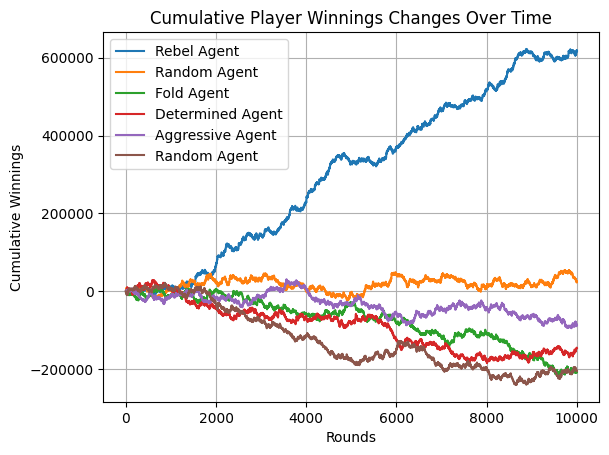

In [117]:
players = ["Rebel Agent", "Random Agent", "Fold Agent", "Determined Agent", "Aggressive Agent", "Random Agent"]

# Compute the running cumulative sum for each player
cumulative_player_stacks = np.cumsum(player_winnings, axis=0)

# Transpose to get stacks per player
cumulative_player_stacks_transposed = cumulative_player_stacks.T

# Plot cumulative stacks for each player
for i, cumulative_stack in enumerate(cumulative_player_stacks_transposed, start=1):
    plt.plot(cumulative_stack, label=f'{players[i-1]}')

# Add labels and legend
plt.xlabel('Rounds')
plt.ylabel('Cumulative Winnings')
plt.title('Cumulative Player Winnings Changes Over Time')
plt.legend()
plt.grid(True)
plt.show()

## 3 Rebels vs 3 Random

In [118]:
active_players = 6
agents = [REBELAgent(active_players), REBELAgent(active_players), RandomAgent(), RandomAgent(), REBELAgent(active_players), RandomAgent()]
player_names = {0: 'TrackedAgent1', 1: 'Agent2'} # Rest are defaulted to player3, player4...
# Should we only log the 0th players (here TrackedAgent1) private cards to hand history files
track_single_player = False
# Bounds for randomizing player stack sizes in reset()
low_stack_bbs = 999
high_stack_bbs = 1000
hand_history_location = 'Hands/'
invalid_action_penalty = 10

table = createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player)
table.seed(2)


In [119]:
n_iterations = 10000
player_winnings = learningLoop(table, agents, active_players, n_iterations)

Iteration: 250
Iteration: 500
Iteration: 750
Iteration: 1000
Iteration: 1250
Iteration: 1500
Iteration: 1750
Iteration: 2000
Iteration: 2250
Iteration: 2500
Iteration: 2750
Iteration: 3000
Iteration: 3250
Iteration: 3500
Iteration: 3750
Iteration: 4000
Iteration: 4250
Iteration: 4500
Iteration: 4750
Iteration: 5000
Iteration: 5250
Iteration: 5500
Iteration: 5750
Iteration: 6000
Iteration: 6250
Iteration: 6500
Iteration: 6750
Iteration: 7000
Iteration: 7250
Iteration: 7500
Iteration: 7750
Iteration: 8000
Iteration: 8250
Iteration: 8500
Iteration: 8750
Iteration: 9000
Iteration: 9250
Iteration: 9500
Iteration: 9750
Iteration: 10000


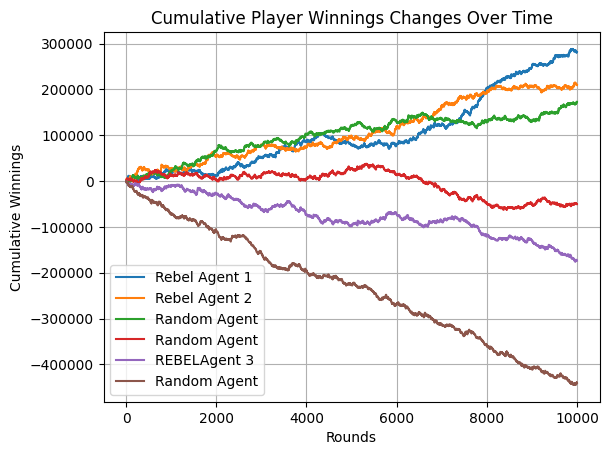

In [120]:
players = ["Rebel Agent 1", "Rebel Agent 2", "Random Agent", "Random Agent", "REBELAgent 3", "Random Agent"]

# Compute the running cumulative sum for each player
cumulative_player_stacks = np.cumsum(player_winnings, axis=0)

# Transpose to get stacks per player
cumulative_player_stacks_transposed = cumulative_player_stacks.T

# Plot cumulative stacks for each player
for i, cumulative_stack in enumerate(cumulative_player_stacks_transposed, start=1):
    plt.plot(cumulative_stack, label=f'{players[i-1]}')

# Add labels and legend
plt.xlabel('Rounds')
plt.ylabel('Cumulative Winnings')
plt.title('Cumulative Player Winnings Changes Over Time')
plt.legend()
plt.grid(True)
plt.show()

## 1 Rebel 3 Q-Learning 2 Random

In [121]:
active_players = 6
agents = [QLearningAgent(), REBELAgent(active_players), RandomAgent(), QLearningAgent(), RandomAgent(), QLearningAgent()]
player_names = {0: 'TrackedAgent1', 1: 'Agent2'} # Rest are defaulted to player3, player4...
# Should we only log the 0th players (here TrackedAgent1) private cards to hand history files
track_single_player = False
# Bounds for randomizing player stack sizes in reset()
low_stack_bbs = 999
high_stack_bbs = 1000
hand_history_location = 'Hands/'
invalid_action_penalty = 10

table = createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player)
table.seed(3)

In [122]:
n_iterations = 10000
player_winnings = learningLoop(table, agents, active_players, n_iterations)

Iteration: 250
Iteration: 500
Iteration: 750
Iteration: 1000
Iteration: 1250
Iteration: 1500
Iteration: 1750
Iteration: 2000
Iteration: 2250
Iteration: 2500
Iteration: 2750
Iteration: 3000
Iteration: 3250
Iteration: 3500
Iteration: 3750
Iteration: 4000
Iteration: 4250
Iteration: 4500
Iteration: 4750
Iteration: 5000
Iteration: 5250
Iteration: 5500
Iteration: 5750
Iteration: 6000
Iteration: 6250
Iteration: 6500
Iteration: 6750
Iteration: 7000
Iteration: 7250
Iteration: 7500
Iteration: 7750
Iteration: 8000
Iteration: 8250
Iteration: 8500
Iteration: 8750
Iteration: 9000
Iteration: 9250
Iteration: 9500
Iteration: 9750
Iteration: 10000


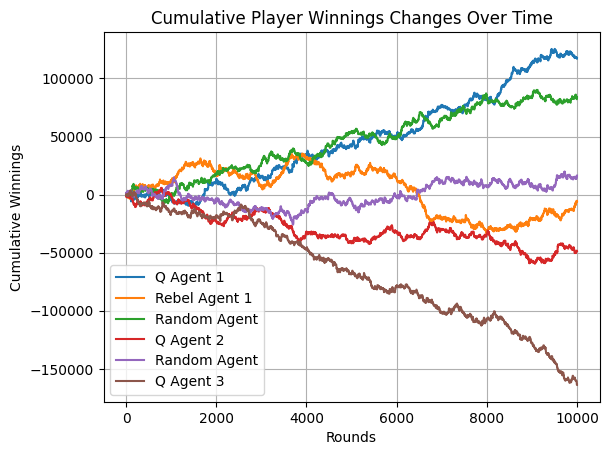

In [123]:
players = ["Q Agent 1", "Rebel Agent 1", "Random Agent", "Q Agent 2", "Random Agent", "Q Agent 3"]

# Compute the running cumulative sum for each player
cumulative_player_stacks = np.cumsum(player_winnings, axis=0)

# Transpose to get stacks per player
cumulative_player_stacks_transposed = cumulative_player_stacks.T

# Plot cumulative stacks for each player
for i, cumulative_stack in enumerate(cumulative_player_stacks_transposed, start=1):
    plt.plot(cumulative_stack, label=f'{players[i-1]}')

# Add labels and legend
plt.xlabel('Rounds')
plt.ylabel('Cumulative Winnings')
plt.title('Cumulative Player Winnings Changes Over Time')
plt.legend()
plt.grid(True)
plt.show()

## 3 Rebel vs 3 Q-Learning

In [124]:
active_players = 6
agents = [QLearningAgent(), REBELAgent(active_players), REBELAgent(active_players), QLearningAgent(), REBELAgent(active_players), QLearningAgent()]
player_names = {0: 'TrackedAgent1', 1: 'Agent2'} # Rest are defaulted to player3, player4...
# Should we only log the 0th players (here TrackedAgent1) private cards to hand history files
track_single_player = False
# Bounds for randomizing player stack sizes in reset()
low_stack_bbs = 999
high_stack_bbs = 1000
hand_history_location = 'Hands/'
invalid_action_penalty = 10

table = createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player)
table.seed(3)

In [125]:
n_iterations = 10000
player_winnings = learningLoop(table, agents, active_players, n_iterations)

Iteration: 250
Iteration: 500
Iteration: 750
Iteration: 1000
Iteration: 1250
Iteration: 1500
Iteration: 1750
Iteration: 2000
Iteration: 2250
Iteration: 2500
Iteration: 2750
Iteration: 3000
Iteration: 3250
Iteration: 3500
Iteration: 3750
Iteration: 4000
Iteration: 4250
Iteration: 4500
Iteration: 4750
Iteration: 5000
Iteration: 5250
Iteration: 5500
Iteration: 5750
Iteration: 6000
Iteration: 6250
Iteration: 6500
Iteration: 6750
Iteration: 7000
Iteration: 7250
Iteration: 7500
Iteration: 7750
Iteration: 8000
Iteration: 8250
Iteration: 8500
Iteration: 8750
Iteration: 9000
Iteration: 9250
Iteration: 9500
Iteration: 9750
Iteration: 10000


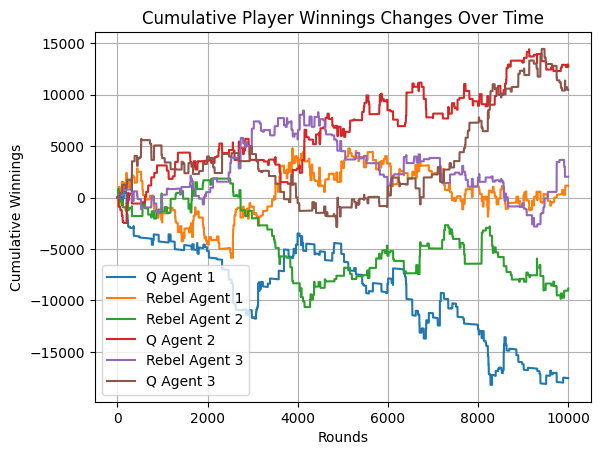

In [126]:
players = ["Q Agent 1", "Rebel Agent 1", "Rebel Agent 2", "Q Agent 2", "Rebel Agent 3", "Q Agent 3"]

# Compute the running cumulative sum for each player
cumulative_player_stacks = np.cumsum(player_winnings, axis=0)

# Transpose to get stacks per player
cumulative_player_stacks_transposed = cumulative_player_stacks.T

# Plot cumulative stacks for each player
for i, cumulative_stack in enumerate(cumulative_player_stacks_transposed, start=1):
    plt.plot(cumulative_stack, label=f'{players[i-1]}')

# Add labels and legend
plt.xlabel('Rounds')
plt.ylabel('Cumulative Winnings')
plt.title('Cumulative Player Winnings Changes Over Time')
plt.legend()
plt.grid(True)
plt.show()

## 1 Rebel vs 5 Q-Learning

In [127]:
active_players = 6
agents = [QLearningAgent(), REBELAgent(active_players), QLearningAgent(), QLearningAgent(), QLearningAgent(), QLearningAgent()]
player_names = {0: 'TrackedAgent1', 1: 'Agent2'} # Rest are defaulted to player3, player4...
# Should we only log the 0th players (here TrackedAgent1) private cards to hand history files
track_single_player = False
# Bounds for randomizing player stack sizes in reset()
low_stack_bbs = 999
high_stack_bbs = 1000
hand_history_location = 'Hands/'
invalid_action_penalty = 10

table = createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player)
table.seed(3)

In [128]:
n_iterations = 10000
player_winnings = learningLoop(table, agents, active_players, n_iterations)

Iteration: 250
Iteration: 500
Iteration: 750
Iteration: 1000
Iteration: 1250
Iteration: 1500
Iteration: 1750
Iteration: 2000
Iteration: 2250
Iteration: 2500
Iteration: 2750
Iteration: 3000
Iteration: 3250
Iteration: 3500
Iteration: 3750
Iteration: 4000
Iteration: 4250
Iteration: 4500
Iteration: 4750
Iteration: 5000
Iteration: 5250
Iteration: 5500
Iteration: 5750
Iteration: 6000
Iteration: 6250
Iteration: 6500
Iteration: 6750
Iteration: 7000
Iteration: 7250
Iteration: 7500
Iteration: 7750
Iteration: 8000
Iteration: 8250
Iteration: 8500
Iteration: 8750
Iteration: 9000
Iteration: 9250
Iteration: 9500
Iteration: 9750
Iteration: 10000


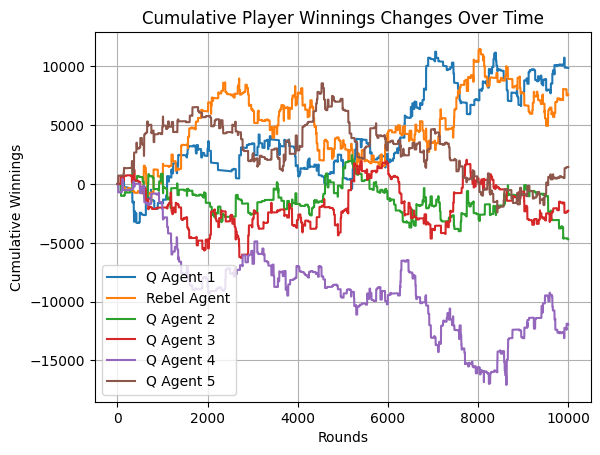

In [129]:
players = ["Q Agent 1", "Rebel Agent", "Q Agent 2", "Q Agent 3", "Q Agent 4", "Q Agent 5"]

# Compute the running cumulative sum for each player
cumulative_player_stacks = np.cumsum(player_winnings, axis=0)

# Transpose to get stacks per player
cumulative_player_stacks_transposed = cumulative_player_stacks.T

# Plot cumulative stacks for each player
for i, cumulative_stack in enumerate(cumulative_player_stacks_transposed, start=1):
    plt.plot(cumulative_stack, label=f'{players[i-1]}')

# Add labels and legend
plt.xlabel('Rounds')
plt.ylabel('Cumulative Winnings')
plt.title('Cumulative Player Winnings Changes Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Rebel vs Q-Learning 1v1

In [130]:
active_players = 2
agents = [REBELAgent(active_players), QLearningAgent()]
player_names = {0: 'Rebel', 1: 'Q'} # Rest are defaulted to player3, player4...
track_single_player = False
# Bounds for randomizing player stack sizes in reset()
low_stack_bbs = 99999
high_stack_bbs = 100000
hand_history_location = 'Hands/'
invalid_action_penalty = 10

table = createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player)
table.seed(4)


In [131]:
n_iterations = 10000
player_winnings = learningLoop(table, agents, active_players, n_iterations)

Iteration: 250
Iteration: 500
Iteration: 750
Iteration: 1000
Iteration: 1250
Iteration: 1500
Iteration: 1750
Iteration: 2000
Iteration: 2250
Iteration: 2500
Iteration: 2750
Iteration: 3000
Iteration: 3250
Iteration: 3500
Iteration: 3750
Iteration: 4000
Iteration: 4250
Iteration: 4500
Iteration: 4750
Iteration: 5000
Iteration: 5250
Iteration: 5500
Iteration: 5750
Iteration: 6000
Iteration: 6250
Iteration: 6500
Iteration: 6750
Iteration: 7000
Iteration: 7250
Iteration: 7500
Iteration: 7750
Iteration: 8000
Iteration: 8250
Iteration: 8500
Iteration: 8750
Iteration: 9000
Iteration: 9250
Iteration: 9500
Iteration: 9750
Iteration: 10000


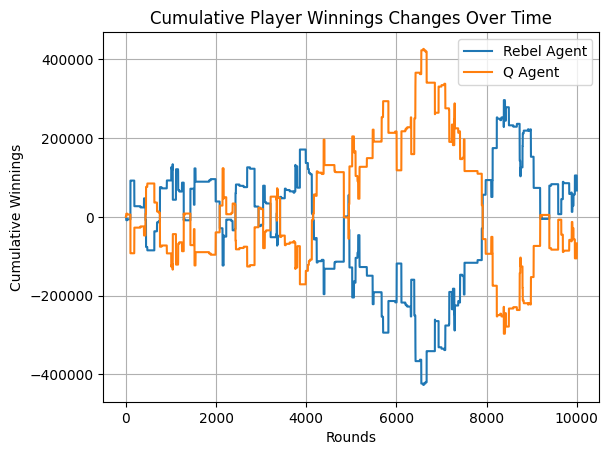

In [132]:
players = ["Rebel Agent", "Q Agent"]

# Compute the running cumulative sum for each player
cumulative_player_stacks = np.cumsum(player_winnings, axis=0)

# Transpose to get stacks per player
cumulative_player_stacks_transposed = cumulative_player_stacks.T

# Plot cumulative stacks for each player
for i, cumulative_stack in enumerate(cumulative_player_stacks_transposed, start=1):
    plt.plot(cumulative_stack, label=f'{players[i-1]}')

# Add labels and legend
plt.xlabel('Rounds')
plt.ylabel('Cumulative Winnings')
plt.title('Cumulative Player Winnings Changes Over Time')
plt.legend()
plt.grid(True)
plt.show()